# Initialization of libraries

In [2]:
# %matplotlib inline
import os
import sys
# import matplotlib

import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import networkx as nx

from datetime import datetime

from sktensor import dtensor, cp_als

# matplotlib.style.use('ggplot')

# Manufacturing company emails

### Importing the dataset

In [3]:
# Looking for the dataset
if not os.path.isdir('radoslaw_email'):
    print 'The dataset has not be found'
else:
    # Loading the dataset
    tab = pd.read_csv('radoslaw_email/out.radoslaw_email_email', sep=' ', skiprows=2, header=None, index_col=False)

In [4]:
# Display
# tab.head()

In [5]:
# Keeping desired columns and naming them
tab.drop(2, axis=1, inplace=True)
tab.columns = ['sender', 'receiver', 'weight', 'datetime']

# Date Time format
tab.datetime = pd.to_datetime(tab.datetime,unit='s')

In [6]:
# Display
# tab.head()

### Quick Data Analysis

In [7]:
# print '%d mails exchanged between %d employees from %s to %s' %(tab.shape[0],
#                                                                 len(pd.unique(pd.concat([tab.sender,tab.receiver]))),
#                                                                 str(min(tab.datetime.dt.date)),
#                                                                 str(max(tab.datetime.dt.date))) 

In [8]:
# tab.datetime.groupby(tab.datetime.dt.week).count().plot(
#     title='Temporal Distribution per week',
#     kind='bar',
#     figsize=(16, 10),
#     color='#348ABD',
#     alpha=0.6,
#     lw='1',
#     edgecolor='#348ABD',
#     grid=True)

### Number of active days / sender

In [9]:
# sent_mails = tab.datetime.dt.date.groupby(tab.sender).nunique()

# sent_mails.describe()

### Number of receivers / sender

In [9]:
# sent_mails = tab.receiver.groupby(tab.sender).nunique()

# sent_mails.describe()

count    154.000000
mean      37.558442
std       31.085584
min        1.000000
25%       12.750000
50%       37.000000
75%       51.750000
max      137.000000
dtype: float64

In [10]:
# sent_mails.argmax()
# max(sent_mails) == len(pd.unique(tab.ix[tab.sender == 38, 1]))

True

### Top senders

In [27]:
# top_senders = tab.sender.groupby(tab.sender).count()
# top_senders.sort(ascending=False)
# top_senders

sender
3         4607
13        3305
59        2884
86        2314
94        2182
50        2140
14        2128
1         2086
15        1997
76        1857
84        1781
4         1723
68        1627
69        1410
53        1210
...
97        6
137       4
159       2
160       2
165       2
155       1
157       1
156       1
154       1
158       1
162       1
163       1
164       1
161       1
167       1
Name: sender, Length: 154, dtype: int64

### Top receivers

In [28]:
# top_receivers = tab.receiver.groupby(tab.receiver).count()
# top_receivers.sort(ascending=False)
# top_receivers

receiver
3           4446
50          3341
13          2944
15          2583
14          2525
94          1974
40          1784
66          1683
69          1591
4           1570
9           1492
56          1356
53          1350
86          1296
1           1290
...
111         26
78          22
133         20
97          16
125         13
126         11
136         11
146          8
114          5
127          4
132          4
131          4
135          3
134          3
166          1
Name: receiver, Length: 140, dtype: int64

### Creating a graph (Dipou's Birthday example)

In [11]:
# dipou_brthd = datetime.strptime('2010-01-19', '%Y-%m-%d')

In [12]:
# row_list = tab.datetime.dt.date == dipou_brthd.date()
# edge_list = zip(tab.sender[row_list], tab.receiver[row_list])

# G=nx.Graph()
# G.add_edges_from(edge_list)

In [13]:
# print '%d mails exchanged between %d employees the %s' %(nx.number_of_edges(G), 
#                                                          nx.number_of_nodes(G), 
#                                                          str(dipou_brthd.date()))

174 mails exchanged between 86 employees the 2010-01-19


C:\Users\Sacha\Anaconda\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Users\Sacha\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


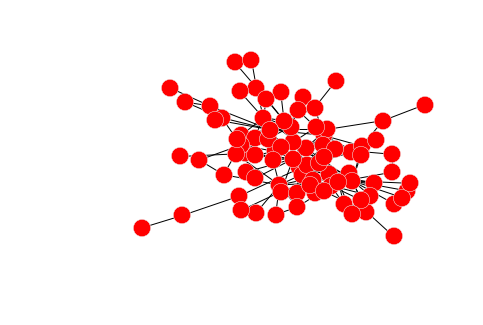

In [14]:
# nx.draw(G)

### Converting datetimes into integers

In [15]:
dates = tab.datetime.dt.date[:]
tab.datetime = dates.apply(lambda dates: dates.toordinal())

## Creating a tensor

### Listing all the unique values of the dataset

In [ ]:
X = tab.iloc[:, [0, 1, 3]]

i_list = pd.unique(X.iloc[:, 0])
j_list = pd.unique(X.iloc[:, 1])
k_list = pd.unique(X.iloc[:, 2])

i_list.sort()
j_list.sort()
k_list.sort()

### Creating and filling the tensor

In [ ]:
T = np.zeros((len(i_list), len(j_list), len(k_list)))
T = dtensor(T)

In [ ]:
# Going through the dataframe
for i, j, k in zip(X.sender, X.receiver, X.datetime):
    # Finding the corresponding index in the tensor
    i_ind = [i_ind for i_ind, x in enumerate(i_list) if x == i][0]
    j_ind = [j_ind for j_ind, x in enumerate(j_list) if x == j][0]
    k_ind = [k_ind for k_ind, x in enumerate(k_list) if x == k][0]
    
    # Modifying the tensor value for the tuple (i_ind, j_ind, k_ind)
    T[i_ind, j_ind, k_ind] += 1

### Useful Code for finding dataframe lines corresponding to given values

In [ ]:
i = 1  # sender "1"
j = 10  # receiver "10"
# k = 

X.ix[(X.sender == i)&(X.receiver == j)].head()  # using "head()" for only showing the 5 first results
# X.ix[(X.sender == i)&(X.receiver == j)&(X.datetime == k)]